# Self-Driving Car Engineer Nanodegree
## Project 3: (Deep Learning) Build a Traffic Sign Recognition Classifier

In this project, I used what I've learned about deep neural networks and convolutional neural networks to classify traffic signs. I trained and validate a model so it can classify traffic sign images using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). After the model is trained.

In [ ]:
# Load and import dependencies 
import numpy as np
import sys
import os

from IPython.display import clear_output, display

import pickle
from sklearn.utils import shuffle

from utils import summary_data_sets, show_dataset, plot_dataset, plot_history, plot_confusion_matrix
from utils import balance_data, rot_pers_transform, rot_pers_transform, add_noisy, gray, norm
from utils import get_img_transformations, load_new_data

import matplotlib.pyplot as plt


---
## Step 1: Dataset Loading, Summary and Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Dataset Loading

In [ ]:
# set where the training and testing data are saved
validation_file = "traffic-signs-data/valid.p"
training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

# Read training dataset file
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

# Read validation dataset file
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)

# Read testing dataset file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# Get features and labels
X_train_raw, y_train_raw = train['features'], train['labels']
X_valid_raw, y_valid_raw = valid['features'], valid['labels']
X_test_raw, y_test_raw = test['features'], test['labels']

# Shuffle all datasets
X_train_raw, y_train_raw = shuffle(X_train_raw, y_train_raw)
X_valid_raw, y_valid_raw = shuffle(X_valid_raw, y_valid_raw)
X_test_raw, y_test_raw = shuffle(X_test_raw, y_test_raw)


### Basic Summary of the Data Set

In [ ]:
n_train = X_train_raw.shape[0] # Number of training examples
n_validation = X_valid_raw.shape[0] # Number of validation examples
n_test = X_test_raw.shape[0] # Number of testing examples.
n_total = n_test + n_validation + n_train # Total number of samples in dataset
image_shape = X_train_raw.shape[1:] # Shape of an traffic sign image

# Get summary of datasets
classes_dics_raw = summary_data_sets(y_train_raw, y_valid_raw, y_test_raw, 'traffic-signs-data/signnames.csv')

# Unique classes/labels in the dataset.
n_classes = len(classes_dics_raw)

# Print datasets report
print("-"*57)
print("| id\t| train\t\t| validation\t| testing\t|")
print("-"*57)
for dic in classes_dics_raw:
    print("| {}\t| {:.2f}% - {}\t| {:.2f}% - {}\t| {:.2f}% - {}\t|  {}".format(
        dic["id"], 
        dic["train"]/n_train*100, dic["train"], 
        dic["vali"]/n_validation*100, dic["vali"], 
        dic["test"]/n_test*100, dic["test"], 
        dic["description"][0:30]))
print("-"*57,"\n")    
print("{:.2f}% - Number of training examples \t= {}".format(n_train/n_total*100, n_train))
print("{:.2f}% - Number of validation examples \t= {}".format(n_validation/n_total*100, n_validation))
print("{:.2f}% - Number of testing examples \t= {}".format(n_test/n_total*100, n_test))
print("\nImage data shape =", image_shape)
print("Number of classes =", n_classes)


### Exploratory Visualization of the Dataset

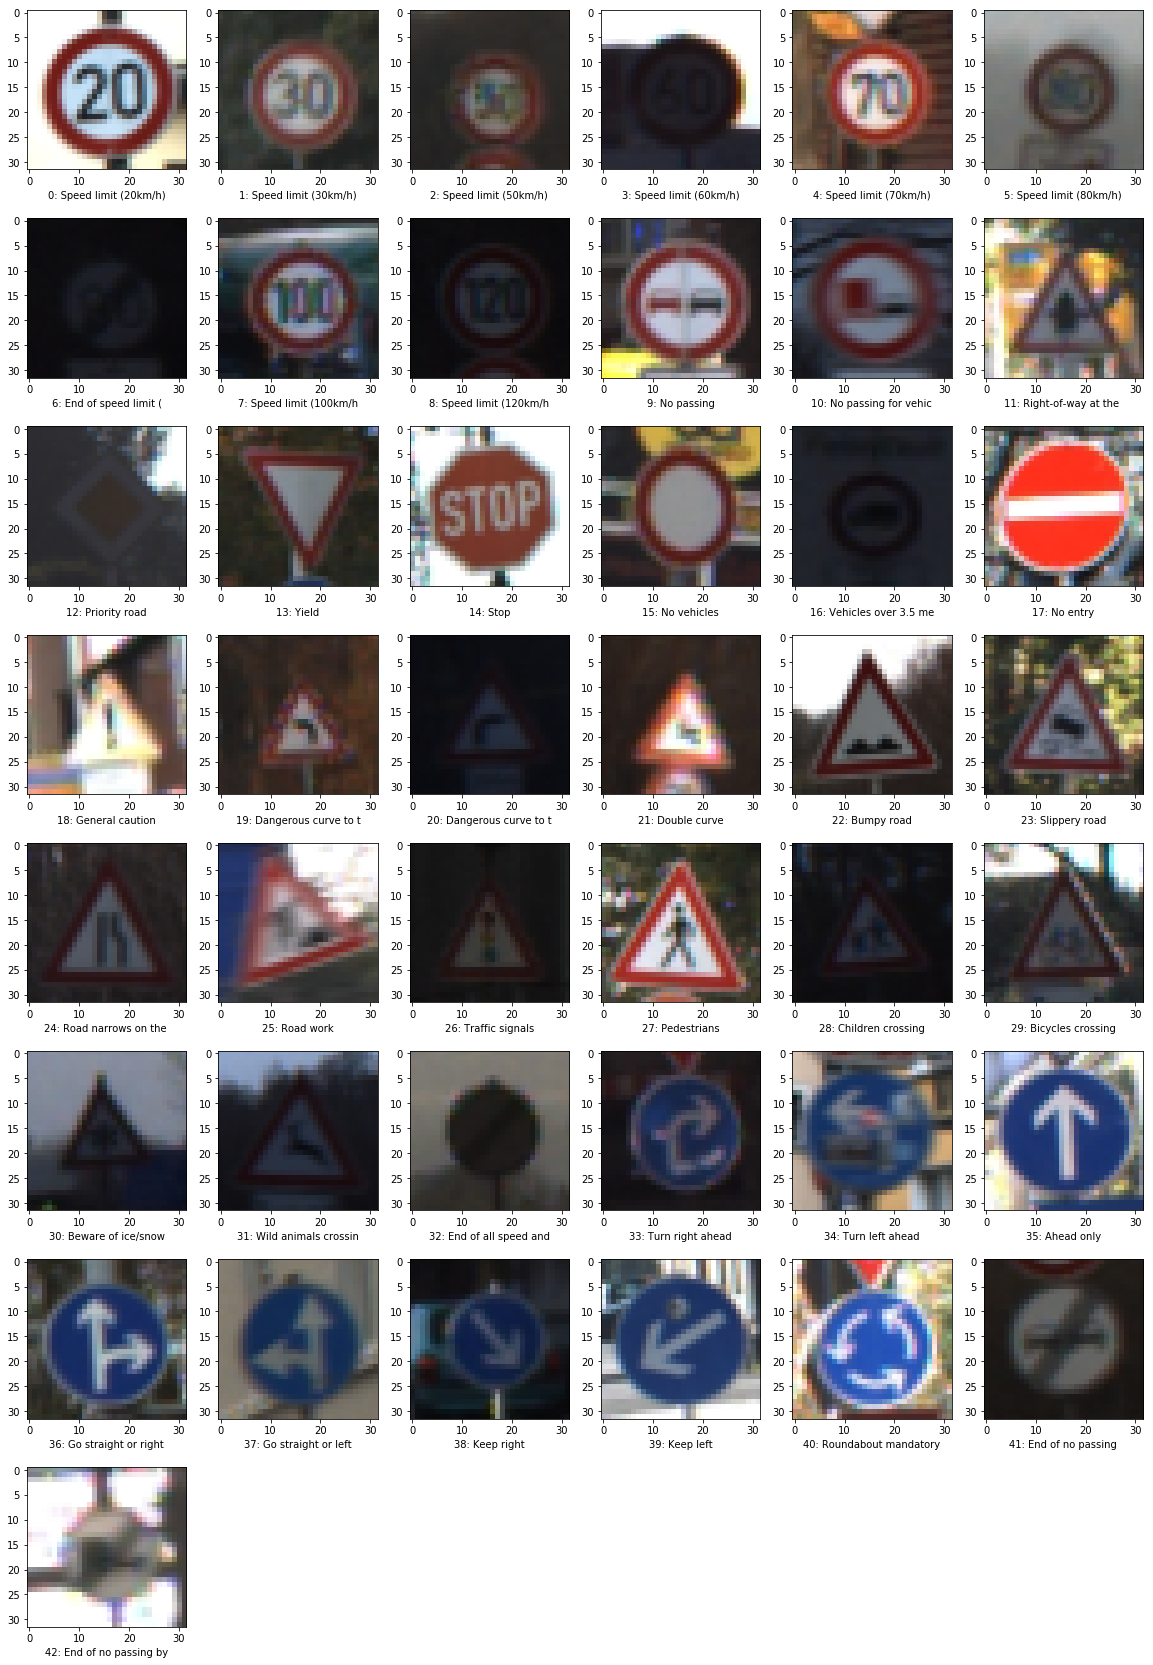

In [13]:
# Show random  datasets samples 
show_dataset(X_train_raw, classes_dics_raw, data_label = "train", save_name = 'writeup_files/dataset_random_visualization.png')


In [ ]:
# Get the total of samples for each class in validation, training and test datasets
means_validation = [d['vali'] for d in classes_dics_raw if 'vali' in d]
means_training = [d['train'] for d in classes_dics_raw if 'train' in d]
means_test = [d['test'] for d in classes_dics_raw if 'test' in d]

# Show a random sample for each class
plot_dataset(means_training, means_validation, means_test, n_classes,save_name = 'writeup_files/dataset_description_original_data.png')


### Data Augmentation:  Data Set Pre-processing

In [ ]:
# Apply data augmentation and balance dataset
X_train_aug, y_train_aug = balance_data(X_train_raw, y_train_raw, classes_dics_raw, data_label = 'train', 
                                        ang=15, d_offset=3, noise=80, desired_samples = 1000)

# Classes dictionaries for new data set
classes_dics = summary_data_sets(y_train_aug, y_valid_raw, y_test_raw, 'traffic-signs-data/signnames.csv')

# Get the total of samples for each class for validation, training and test data sets
means_training = [d['train'] for d in classes_dics if 'train' in d]

# Plot dataset samples distribution
plot_dataset(means_training, means_validation, means_test, n_classes, save_name = 'writeup_files/dataset_description_balanced_data.png')

# Show random samples for each class
show_dataset(X_train_aug, classes_dics, data_label = "train", save_name = 'writeup_files/dataset_random_visualization_balanced.png')


In [ ]:
# Get a random sample to apply modifications
idx = np.random.randint(len(X_valid_raw))
X_valid_image = X_valid_raw[idx]
get_img_transformations(X_valid_image)


----

## Step 2: Designing, Training and Testing a Model Architecture

Next the designing and implementation of a deep learning model that learns to recognize traffic signs. Model was trained and tested with the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). The Network is inspired in the [LeNet-5](http://yann.lecun.com/exdb/lenet/) implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) and the lecture [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

Various aspects were considered in this problem:
- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.


### Input
Architecture accepts a 32x32xC image (`x`) as input, where C is the number of color channels setted in the variable `NUM_CHANNELS`.

### Architecture
**Layer 1: Convolutional.** The output shape is 28x28x26.  
**Activation.** Relu as activation function.  
**Pooling.** The output shape should be 14x14x26.  

**Layer 2: Convolutional.** The output shape is 10x10x64.  
**Activation.** Relu as activation function.  
**Pooling.** The output shape should be 5x5x64.  
**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The output is flatten vector of 1600  
**Dropout.** with probability of 50%

**Layer 3: Fully Connected.** 120 outputs.  
**Activation.** Relu as activation function.  
**Dropout.** with probability of 50%

**Layer 4: Fully Connected.** outputs 84.  
**Activation.** Relu as activation function.  
**Dropout.** with probability of 50%

**Layer 5**: Fully Connected (Logits). 43 (NUmber of calsses) outputs.  

### Output
Return the logits of all full conected network and Layer 1 (`conv1`) and Layer 2 (`conv2`).

In [4]:
# Load and import dependencies for model
import tensorflow as tf
from tensorflow.contrib.layers import flatten


In [5]:
# BEST REULTS: BATCH_SIZE=128, LEARNING_RATE = 0.0005, NUM_CHANNELS=3, EPOCHS = 150, DATA_AUGMENTA=1

# Hyper parameters
DATA_SRC_SIZE = (32, 32)
MODEL_NAME = "BetaNet"
BATCH_SIZE = 128
LEARNING_RATE = 0.0005
NUM_CHANNELS = 3
EPOCHS = 150
DATA_AUGMENTA = 1


In [6]:
def BetaNet(x, keep_prob, mu = 0, sigma = 0.1, ):
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases 
    # for each layer
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28xconv_1_d.
    conv_1_d = 24
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, NUM_CHANNELS, conv_1_d), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(conv_1_d))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14xconv_1_d
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 14x14xconv_1_d Output = 10x10xconv_2_d.
    conv_2_d = 64
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, conv_1_d, conv_2_d), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(conv_2_d))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2) # Activation.
    # Pooling. Input = 10x10x16. Output = 5x5xconv_2_d.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Flatten. Input = 5x5x16. Output = 1600.
    fc0 = flatten(conv2)
    fc0  = tf.nn.dropout(fc0, keep_prob)
    
    # Layer 3: Fully Connected. Input = 1600. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1) # Activation.
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.relu(fc2) # Activation.
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, conv1, conv2

# Evaluate how well the loss and accuracy of the model for a given dataset.
def evaluate(X_data, y_data):
    num_examples = float(len(X_data))
    total_accuracy = 0.
    sess = tf.get_default_session()
    for offset in range(0, int(num_examples), BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, kp: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


tf.reset_default_graph() # Reset any previous graph
x = tf.placeholder(tf.float32, (None, DATA_SRC_SIZE[0], DATA_SRC_SIZE[1], NUM_CHANNELS))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
kp = tf.placeholder(tf.float32) # Probability for dropout

logits, conv1, conv2 = BetaNet(x, kp)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Data Pre-processing

In [25]:
# Dataset selection and adjusments
if NUM_CHANNELS == 1: # Convert dataset to gray scale
    X_train = np.asarray([norm(gray(img)) for img in (X_train_aug if DATA_AUGMENTA else X_train_raw)])
    X_valid = np.asarray([norm(gray(img)) for img in X_valid_raw])
    X_test = np.asarray([norm(gray(img)) for img in X_test_raw])
else:
    X_train = np.asarray([norm(img) for img in (X_train_aug if DATA_AUGMENTA else X_train_raw)])
    X_valid = np.asarray([norm(img) for img in X_valid_raw])
    X_test = np.asarray([norm(img) for img in X_test_raw])
    
y_train = y_train_aug if DATA_AUGMENTA else y_train_raw
y_valid = y_valid_raw
y_test  = y_test_raw


NameError: name 'X_train_aug' is not defined

### Model Training
Run the training data through the training pipeline to train the model.
Before each epoch, shuffle the training set.
After each epoch, measure the loss and accuracy of the validation set.
Save the model after training.
You do not need to modify this section.

In [ ]:
# Training history variables
best_epoch = 0
best_val_acc = 0
history = []
patience = int(EPOCHS*0.5)
keep_prob = 0.5

with tf.Session() as sess:
            
    sess.run(tf.global_variables_initializer())
    print("Training {}...".format(MODEL_NAME))
    
    try:
        for i in range(EPOCHS):
            
            # shuffle data
            X_train, y_train = shuffle(X_train, y_train)
            
            for offset in range(0, len(X_train), BATCH_SIZE):
                end = offset + BATCH_SIZE
                # Select training batch
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                # Run train for batch
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, kp: keep_prob})
                
            # Evaluate model at epoch
            train_acc = evaluate(X_train, y_train)
            valid_acc = evaluate(X_valid, y_valid)
                     
            # Print training process information
            clear_output(wait=True)
            print("EPOCH {}: Tra_Acc:{:.3f} - Val_Acc:{:.3f} - Best_Val_Acc:{:.3f}".format(
                i+1, train_acc, valid_acc, best_val_acc))
            
            history.append([train_acc, valid_acc])   
            if valid_acc > best_val_acc:
                best_epoch, best_val_acc = i, valid_acc
                saver.save(sess, './model_results/{}.ckpt'.format(MODEL_NAME))
                print("Model saved")
            else:
                if i - best_epoch == patience:
                    print('Stopping after {} epochs without improvement'.format(patience))
                    break
        print("Training has finished")

    except KeyboardInterrupt:
        pass


In [ ]:
# Training visualization
plot_history(history, "model_results/model_traing_history.png")


### Testing The Model With Test Dataset

In [ ]:
# Restore the session
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model_results'))
    
    # Evaluate the tesiting dataset
    test_accuracy = evaluate(X_test, y_test)
    print('Test accuracy: {:.3f}%'.format(test_accuracy* 100))
    
    # Take softmax from logits to get predictions
    softmax = tf.nn.softmax(logits)
    t_pred = None
    
    # Select testing batch and test
    for offset in range(0, len(X_test), BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_test[offset:end], y_test[offset:end]
        top_softmax = sess.run(tf.nn.top_k(softmax, k=3), feed_dict={x: batch_x, y: batch_y, kp: 1.0})
    
        if t_pred is None:
            t_pred = top_softmax[1]
        else:
            t_pred = np.concatenate([t_pred, top_softmax[1]])
    
    correct = np.sum([1 for t_pred, actual in zip(t_pred, y_test) if actual in t_pred])
    print('Top-3 test accuracy: {:.3f}%'.format(100 * correct / len(y_test)))
    

### Plot Testing Results

In [ ]:
np.set_printoptions(precision=2)
classes_names= np.asarray([str(i) for i in range(n_classes)])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, t_pred[:, 0], classes=classes_names, 
                      title='Confusion matrix, without normalization', figsize=(60,40))
plt.savefig("./writeup_files/Confusion_matrix_without_normalization.png")

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, t_pred[:, 0], classes=classes_names, normalize=True,
                      title='Normalized confusion matrix', figsize=(60,40))
plt.savefig("./writeup_files/Normalized_confusion_matrix.png")

plt.show()


### Plot Classes Classification Results

---

## Step 3: Test a Model on New Images

To give more insight into how the model is working, more data was randomly downloaded from the web and used in the model to predict the traffic sign type.


### Loading New Data sets

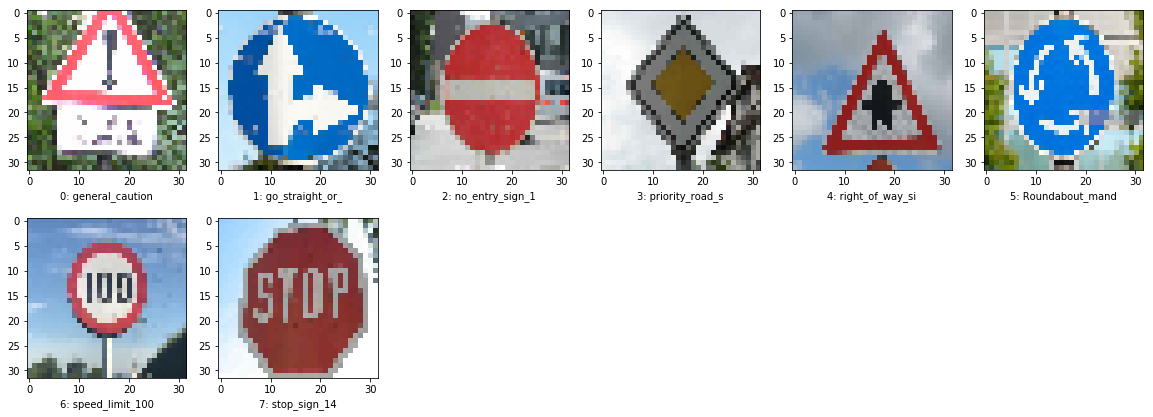

In [15]:
# Load new testing dataset
X_test_new, y_test_new = load_new_data("traffic-signs-data/other_signs", (32, 32), True, 'writeup_files/new_data_set.png')
X_test_new = np.asarray([norm(gray(img)) for img in X_test_new]) if NUM_CHANNELS == 1 else np.asarray([norm(img) for img in X_test_new])
    

### Testing Model with New Data sets

In [20]:
# Run classifier with new testing samples
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model_results'))
    softmax = tf.nn.softmax(logits)
    top_softmax = sess.run(tf.nn.top_k(softmax, k=3), feed_dict={x: X_test_new, kp: 1.0})
    

INFO:tensorflow:Restoring parameters from ./model_results/BetaNet.ckpt


In [ ]:
# Plot results
columns = 2
plt.figure(figsize=(30,40))
for idx in range(0, len(X_test_new)):
    
    ax = plt.subplot(len(X_test_new), 2, 1+idx)
    plt.imshow((X_test_new[idx]*128+128).astype(int))

    val = rand(3), pos = arange(3)+.5    

    ax = plt.subplot(len(X_test_new), 2, 2+idx)
    ax.barh(pos, val, align='center',height=0.1)
    ax.set_yticks(pos, ('class1', 'class2', 'class3'))
    ax.axvline(0,color='k',lw=3
    ax.set_xlabel('Confidence')
    ax.set_title('Class')
    ax.grid(True)
#     plt.show()


### Visualizing Layers

In [22]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1, save_name = None):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(np.ceil(featuremaps/2), 6, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
        if save_name is not None:
            plt.savefig(save_name)
        

In [24]:
with tf.Session() as sess:
    test_accuracy = evaluate(X_test, y_test)
    saver.restore(sess, tf.train.latest_checkpoint('./model_results'))
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    outputFeatureMap([X_train[0]], conv1, plt_num=1, save_name = "writeup_files/visualization_layer_1.png")
    outputFeatureMap([X_train[0]], conv2, plt_num=2, save_name = "writeup_files/visualization_layer_2.png")
    

NameError: name 'X_test' is not defined